In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

  
df = pd.read_csv('train.csv')
train=df
train.insert(2,"clean",train['toxic']^1)
train_comments = train['comment_text']
train_toxic_comments=df.loc[train['toxic'] == 1]
df= pd.read_csv('test.csv')
test=df

test_comments=df['comment_text']
train.head()


,id,comment_text,clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,1,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",1,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,0,0,0,0,0,0


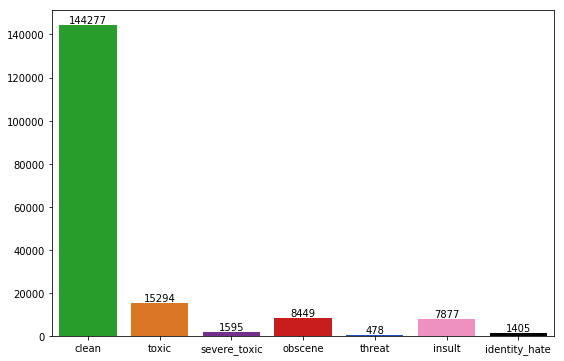

In [58]:
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
colors_list = ["green", "orange", "purple",
               "red", "blue", "pink", "black"]

palette= sns.xkcd_palette(colors_list)

x=train.iloc[:,2:].sum()

plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

toxic count- 15294
original word cloud of toxic


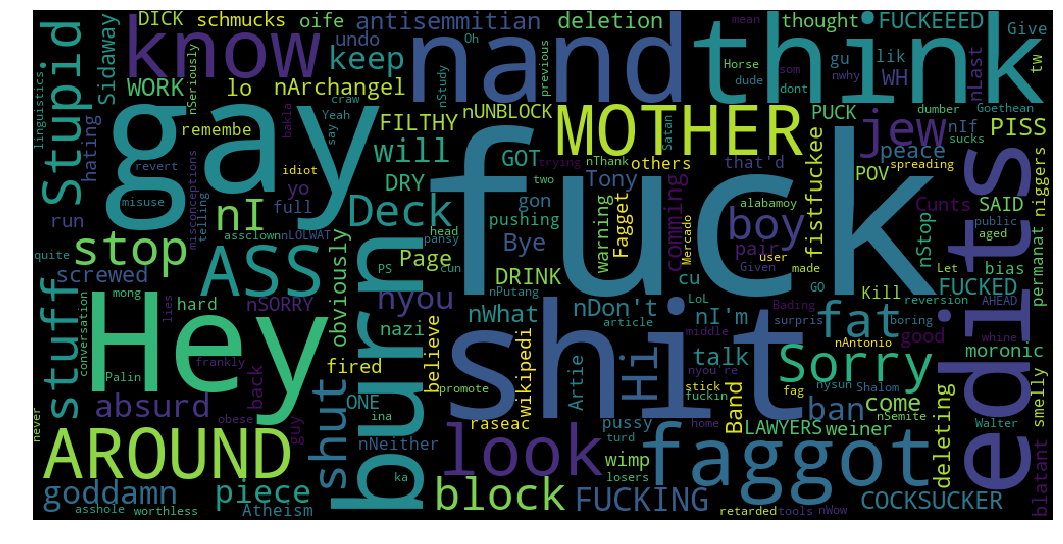

In [59]:
# import matplotlib as mpl
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS



r_train = train[train.toxic == 1]
print ("toxic count-",len(r_train))
print ("original word cloud of toxic")
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 1000, height = 500,
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200
                         ).generate(str(r_train['comment_text']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    stop_words='english',
    ngram_range=(1,1),
    )
word_vectorizer.fit(train_comments)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [61]:
train_vect=word_vectorizer.transform(train_comments)
test_vect=word_vectorizer.transform(test_comments)

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):



    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

CV score for class toxic is 0.9446140122311426


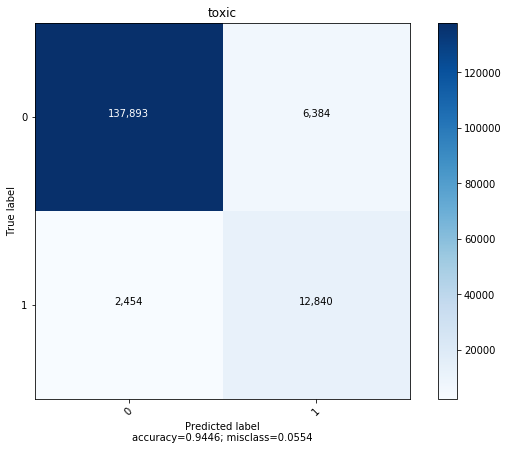

CV score for class severe_toxic is 0.9779909921826864


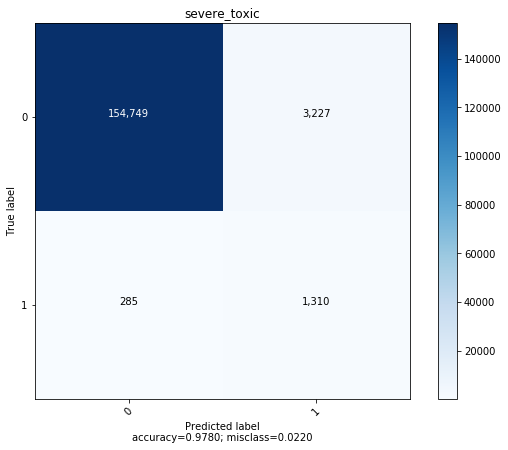

CV score for class obscene is 0.975177198117618


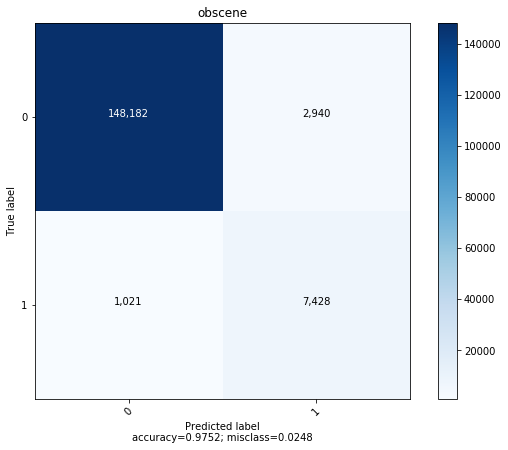

CV score for class threat is 0.9932067859233793


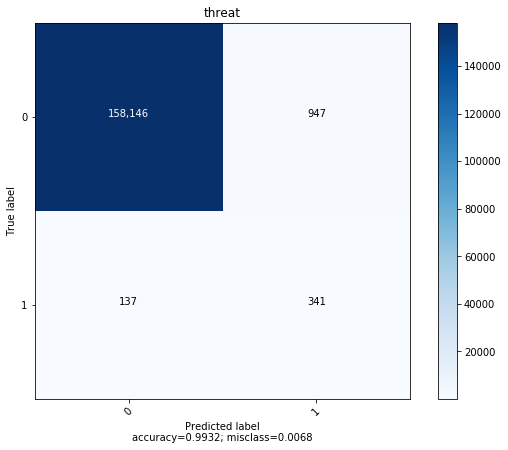

CV score for class insult is 0.9614153021209277


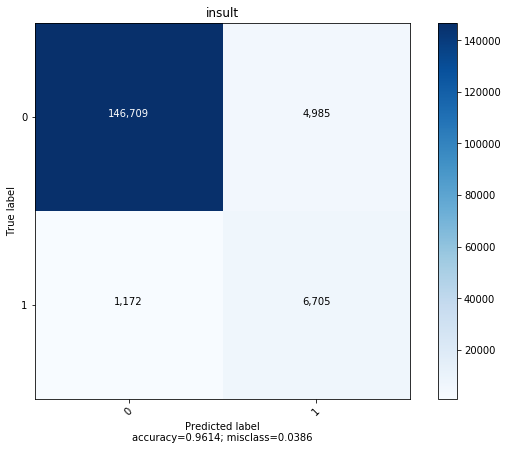

CV score for class identity_hate is 0.9798083648175144


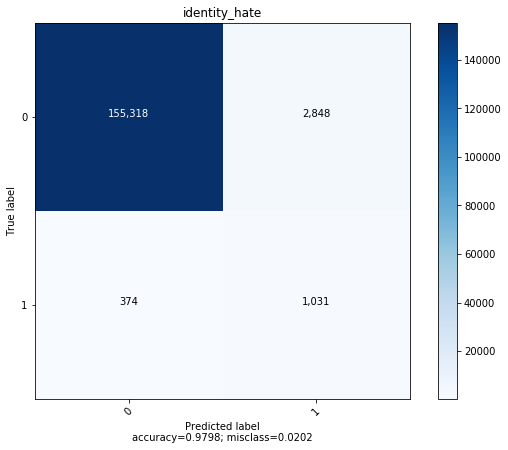

Total CV score is 0.9720354425655447


In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

scores = []
log_loss_scores=[]
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(class_weight='balanced')
    
    cv_score = np.mean(cross_val_score(classifier, train_vect, train_target, cv=5))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    #cv_score = np.mean(cross_val_score(classifier, train_vect, train_target, cv=5,scoring='neg_log_loss'))
    #log_loss_scores.append(cv_score)
    #print('CV neg_log_loss_score for class {} is {}'.format(class_name, cv_score))

    
    classifier.fit(train_vect, train_target)
    submission[class_name] = classifier.predict_proba(test_vect)[:, 1]
    predictions=cross_val_predict(classifier,train_vect,train_target,cv=5)
    conf_mat = confusion_matrix(train_target,predictions)
    #print(conf_mat)
    plot_confusion_matrix(cm = conf_mat, 
                      normalize    = False,
                      target_names = ['0','1'],
                      title        = class_name)
    
print('Total CV score is {}'.format(np.mean(scores)))
#print('Total CV neg_log_loss_score is {}'.format(np.mean(log_loss_scores)))
submission.to_csv('submission.csv', index=False)

In [89]:
df=pd.DataFrame(["you are a nice person but you suck"],columns=['comment'])
comment=df['comment']

vect=word_vectorizer.transform(comment)
#print(vect)
classifier.fit(train_vect,train["toxic"])
classifier.predict_proba(vect)[:, 1]

array([0.99864175])

In [7]:
clean_data=train.loc[train['clean'] == 1]

clean_data.describe()


,clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,144277.0,144277.0,144277.0,144277.000000,144277.000000,144277.000000,144277.000000
mean,1.0,0.0,0.0,0.003625,0.000201,0.003694,0.000714
std,0.0,0.0,0.0,0.060099,0.014176,0.060668,0.026710
min,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
max,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


In [8]:
toxic_data=train.loc[train['clean'] == 0]
toxic_data.describe()

,clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,15294.0,15294.0,15294.000000,15294.000000,15294.000000,15294.000000,15294.000000
mean,0.0,1.0,0.104289,0.518242,0.029358,0.480188,0.085131
std,0.0,0.0,0.305645,0.499683,0.168813,0.499624,0.279086
min,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000
max,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
even_data=pd.concat([toxic_data,clean_data.sample(15294)])
even_data.describe()

,clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,30588.000000,30588.000000,30588.000000,30588.000000,30588.000000,30588.000000,30588.000000
mean,0.500000,0.500000,0.052145,0.260919,0.014777,0.241925,0.042958
std,0.500008,0.500008,0.222322,0.439143,0.120661,0.428256,0.202766
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


CV score for class toxic is 0.8961358489065386
CV neg_log_loss_score for class toxic is -0.29045811802193267


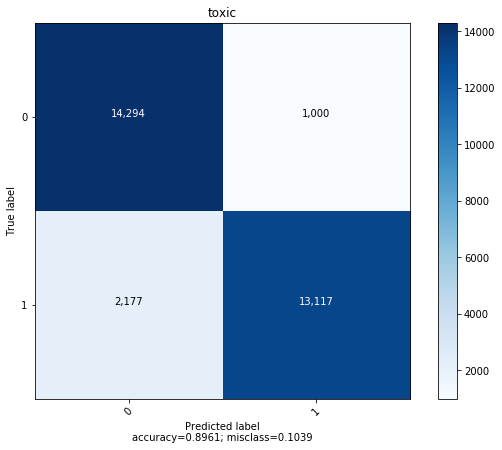

CV score for class severe_toxic is 0.9490000936836835
CV neg_log_loss_score for class severe_toxic is -0.13850122050470046


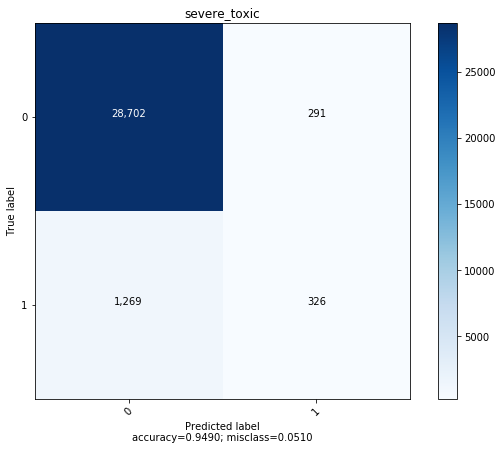

CV score for class obscene is 0.8988193917163712
CV neg_log_loss_score for class obscene is -0.25164851037759683


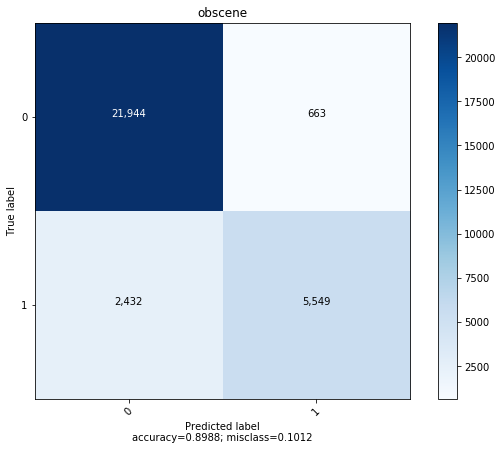

CV score for class threat is 0.985680846932788
CV neg_log_loss_score for class threat is -0.04934009749765566


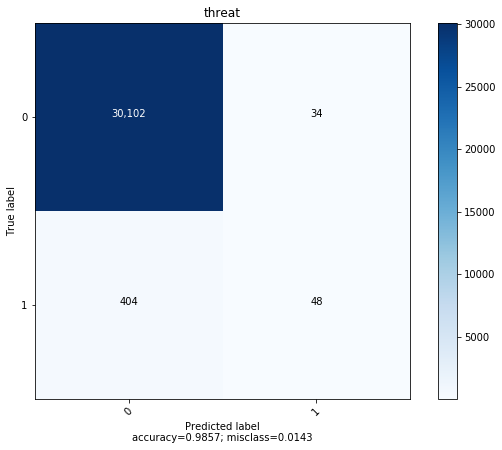

CV score for class insult is 0.8531143999624197
CV neg_log_loss_score for class insult is -0.3322101029090332


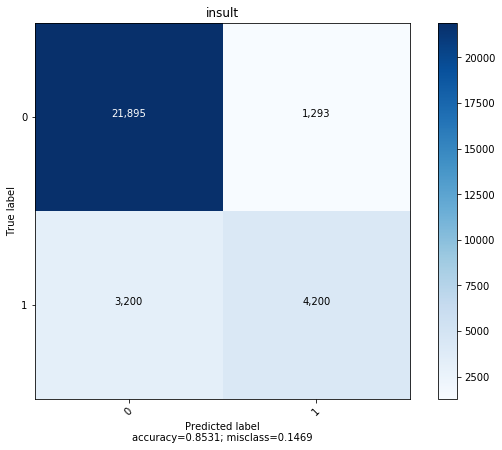

CV score for class identity_hate is 0.9604747572859125
CV neg_log_loss_score for class identity_hate is -0.11770622515655652


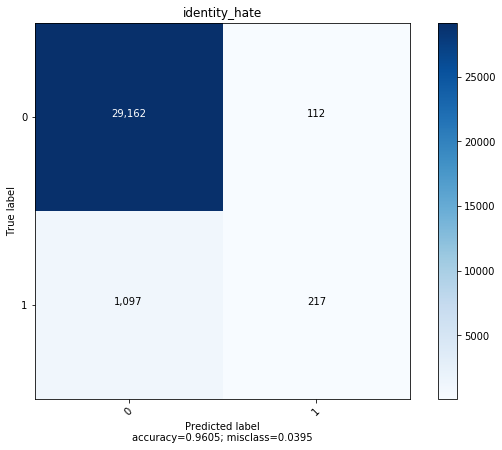

Total CV score is 0.9238708897479523
Total CV neg_log_loss_score is -0.19664404574457925


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
train_comments_even=even_data['comment_text']
train_vect=word_vectorizer.transform(train_comments_even)

scores = []
log_loss_scores=[]
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = even_data[class_name]
    classifier = LogisticRegression()
    
    cv_score = np.mean(cross_val_score(classifier, train_vect, train_target, cv=5))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    cv_score = np.mean(cross_val_score(classifier, train_vect, train_target, cv=5,scoring='neg_log_loss'))
    log_loss_scores.append(cv_score)
    print('CV neg_log_loss_score for class {} is {}'.format(class_name, cv_score))

    
    classifier.fit(train_vect, train_target)
    predictions=cross_val_predict(classifier,train_vect,train_target,cv=5)
    conf_mat = confusion_matrix(train_target,predictions)
    #print(conf_mat)
    plot_confusion_matrix(cm = conf_mat, 
                      normalize    = False,
                      target_names = ['0','1'],
                      title        = class_name)
    
print('Total CV score is {}'.format(np.mean(scores)))
print('Total CV neg_log_loss_score is {}'.format(np.mean(log_loss_scores)))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D,GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.models import Model

max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_comments) + list(test_comments))
train_tokenized = tokenizer.texts_to_sequences(train_comments)
test_tokenized = tokenizer.texts_to_sequences(test_comments)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
maxlen = 150
X_t = pad_sequences(train_tokenized, maxlen=maxlen)
X_te = pad_sequences(test_tokenized, maxlen=maxlen)
inp = Input(shape=(maxlen, ))
embed_size = 300

C:\Users\Atakan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:

x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print("start fitting...")
model.fit(X_t,y, epochs=1, batch_size=32, validation_split=0.1)

print("start predicting...")
y_pred = model.predict(X_te, batch_size=1024)

submission = pd.DataFrame.from_dict({'id': test['id']})
for idx, col in enumerate(list_classes):
    submission[col] = y_pred[:,idx]
submission.to_csv('submission_lstm.csv', index=False)

In [3]:
embeddings_index = {}
with open("glove.6B.300d.txt", encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [5]:
inp = Input(shape=(maxlen,))

x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = SpatialDropout1D(0.2)(x)
x1 = Bidirectional(LSTM(128, return_sequences=True))(x)
x2 = Bidirectional(LSTM(64, return_sequences=True))(x)
conc = concatenate([x1, x2])
#x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
#x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)
#x=GlobalAveragePooling1D()(x)
avg_pool = GlobalAveragePooling1D()(conc)
max_pool = GlobalMaxPooling1D()(conc)
conc = concatenate([avg_pool, max_pool])
x = Dense(64, activation='relu')(conc)
x = Dropout(0.2)(x)
out = Dense(6, activation="sigmoid")(x)

#out = Dense(6, activation='sigmoid')(x)

model = Model(inp, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("start fitting...")
model.fit(X_t,y, epochs=, batch_size=32, verbose =1)

print("start predicting...")
y_pred = model.predict(X_te, batch_size=1024)

submission = pd.DataFrame.from_dict({'id': test['id']})
for idx, col in enumerate(list_classes):
    submission[col] = y_pred[:,idx]
submission.to_csv('submission_lstm_glove.csv', index=False)

start fitting...
Epoch 1/2
159571/159571 [==============================] - 4412s 28ms/step - loss: 0.0528 - acc: 0.9810
Epoch 2/2
159571/159571 [==============================] - 5073s 32ms/step - loss: 0.0389 - acc: 0.9847
start predicting...


In [8]:
 model.output_shape

(None, 6)

In [13]:
import nltk
import gensim
import multiprocessing
nltk.download('stopwords')
train_comments.head(10)

C:\Users\Atakan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Atakan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [14]:

train_comments = train_comments.str.replace('[^a-zA-Z]',' ').str.lower()
test_comments = test_comments.str.replace('[^a-zA-Z]',' ').str.lower()
stop_re = '\\b'+'\\b|\\b'.join(nltk.corpus.stopwords.words('english'))+'\\b'
train_comments = train_comments.str.replace(stop_re, '')
test_comments = test_comments.str.replace(stop_re, '')
train_comments = train_comments.str.split()
test_comments = test_comments.str.split()
train_comments.head(10)

0    [explanation, edits, made, username, hardcore,...
1    [aww, matches, background, colour, seemingly, ...
2    [hey, man, really, trying, edit, war, guy, con...
3    [make, real, suggestions, improvement, wondere...
4                  [sir, hero, chance, remember, page]
5      [congratulations, well, use, tools, well, talk]
6                     [cocksucker, piss, around, work]
7    [vandalism, matt, shirvington, article, revert...
8    [sorry, word, nonsense, offensive, anyway, int...
9            [alignment, subject, contrary, dulithgow]
Name: comment_text, dtype: object

In [15]:
phrases = gensim.models.phrases.Phrases(train_comments.tolist())
phraser = gensim.models.phrases.Phraser(phrases)
train_phrased = phraser[train_comments.tolist()]
cpu_count=multiprocessing.cpu_count()
cpu_count

8

In [16]:
model = gensim.models.word2vec.Word2Vec(sentences=train_phrased,workers=cpu_count)
model.save('w2v_v1')

In [23]:
vectors = model.wv
vectors.most_similar('ugly')

[('retarded', 0.8759980201721191),
 ('fucked', 0.85389244556427),
 ('crazy', 0.8529228568077087),
 ('dumb', 0.8521840572357178),
 ('butt', 0.8422632217407227),
 ('smart', 0.8418364524841309),
 ('cuz', 0.8391885757446289),
 ('blind', 0.8271546959877014),
 ('youre', 0.8258074522018433),
 ('crying', 0.8237015008926392)]

In [19]:
vectors.most_similar('great')

[('wonderful', 0.7199149131774902),
 ('excellent', 0.6216270923614502),
 ('good', 0.5966461896896362),
 ('amazing', 0.5933056473731995),
 ('helped', 0.5839738249778748),
 ('perfect', 0.583441436290741),
 ('fantastic', 0.5742251873016357),
 ('awesome', 0.5728024840354919),
 ('beautiful', 0.5644302368164062),
 ('brilliant', 0.5603110790252686)]

In [4]:
df = pd.read_csv('turkce_yorumlar.csv')
df.head()
df.describe()
train=df
#train.insert(2,"clean",train['toxic']^1)
train_comments = train['yorum']
y= train["toxic"]


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    max_df=0.7,
    ngram_range=(1,1),
    )
word_vectorizer.fit(train_comments)
X_t=word_vectorizer.transform(train_comments)
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=42)

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D,GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.models import Model

max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_comments))
train_tokenized = tokenizer.texts_to_sequences(train_comments)


y = train["toxic"].values
maxlen = 150
X_t = pad_sequences(train_tokenized, maxlen=maxlen)
inp = Input(shape=(maxlen, ))
embed_size = 300


In [13]:
from sklearn.metrics import confusion_matrix
inp = Input(shape=(150,))

x = Embedding(max_features, embed_size)(inp)
x1 = Bidirectional(LSTM(128, return_sequences=True))(x)
x2 = Bidirectional(LSTM(64, return_sequences=True))(x)
conc = concatenate([x1, x2])
#x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
#x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)
#x=GlobalAveragePooling1D()(x)
avg_pool = GlobalAveragePooling1D()(conc)
max_pool = GlobalMaxPooling1D()(conc)
conc = concatenate([avg_pool, max_pool])
x = Dense(64, activation='relu')(conc)
x = Dropout(0.2)(x)
out = Dense(1, activation="sigmoid")(x)

#out = Dense(6, activation='sigmoid')(x)

model = Model(inp, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("start fitting...")
model.fit(X_t,y, epochs=1, batch_size=32, verbose =1,validation_split=0.1)
#model.fit(X_train,y_train, epochs=1, batch_size=32, verbose =1)
#y_pred = model.predict(X_test)
#y_pred= y_pred.argmax(axis=-1)
#conf = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm = conf, normalize= False, target_names = ['0','1'],title= "toxic")




start fitting...
Train on 377 samples, validate on 42 samples
Epoch 1/1
377/377 [==============================] - 15s 40ms/step - loss: 0.6054 - acc: 0.7215 - val_loss: 0.4082 - val_acc: 1.0000


In [14]:
test_str="ananı sikem"
token=tokenizer.texts_to_sequences(test_str)
token_str=pad_sequences(token, maxlen=maxlen)
model.predict(token_str)

array([[0.3363439 ],
       [0.33904856],
       [0.3363439 ],
       [0.33904856],
       [0.33904856],
       [0.33904856],
       [0.33904856],
       [0.33904856],
       [0.33904856],
       [0.33904856],
       [0.3370748 ]], dtype=float32)

CV score for class toxic is 0.9334073251942288
CV neg_log_loss_score for class toxic is -0.4422313923663105


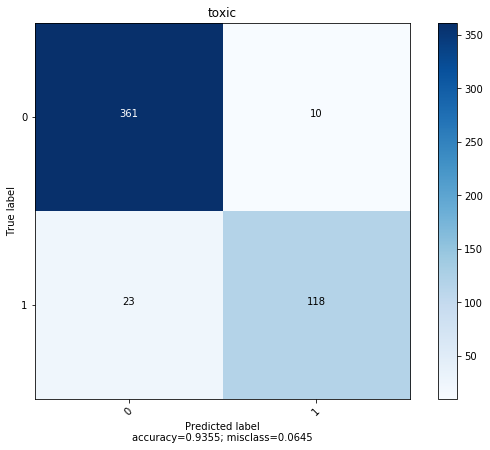

Total CV score is 0.9334073251942288
Total CV neg_log_loss_score is -0.4422313923663105


In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
scores = []
log_loss_scores=[]


train_target = train["toxic"]
classifier = LogisticRegression(class_weight='balanced')
    
cv_score = np.mean(cross_val_score(classifier, X_t, train_target, cv=10))
scores.append(cv_score)
print('CV score for class {} is {}'.format("toxic", cv_score))
cv_score = np.mean(cross_val_score(classifier, X_t, train_target, cv=10,scoring='neg_log_loss'))
log_loss_scores.append(cv_score)
print('CV neg_log_loss_score for class {} is {}'.format("toxic", cv_score))

    
    
predictions=cross_val_predict(classifier,X_t,train_target,cv=5)
conf_mat = confusion_matrix(train_target,predictions)
#print(conf_mat)
plot_confusion_matrix(cm = conf_mat, 
                      normalize    = False,
                      target_names = ['0','1'],
                      title        = "toxic")
    
print('Total CV score is {}'.format(np.mean(scores)))
print('Total CV neg_log_loss_score is {}'.format(np.mean(log_loss_scores)))


In [53]:
df=pd.DataFrame(["orospu"],columns=['comment'])
comment=df['comment']

vect=word_vectorizer.transform(comment)
print(vect)
classifier.fit(X_t,train_target)
classifier.predict_proba(vect)

  (0, 1068)	1.0


array([[0.15920625, 0.84079375]])

toxic count- 105
original word cloud of toxic


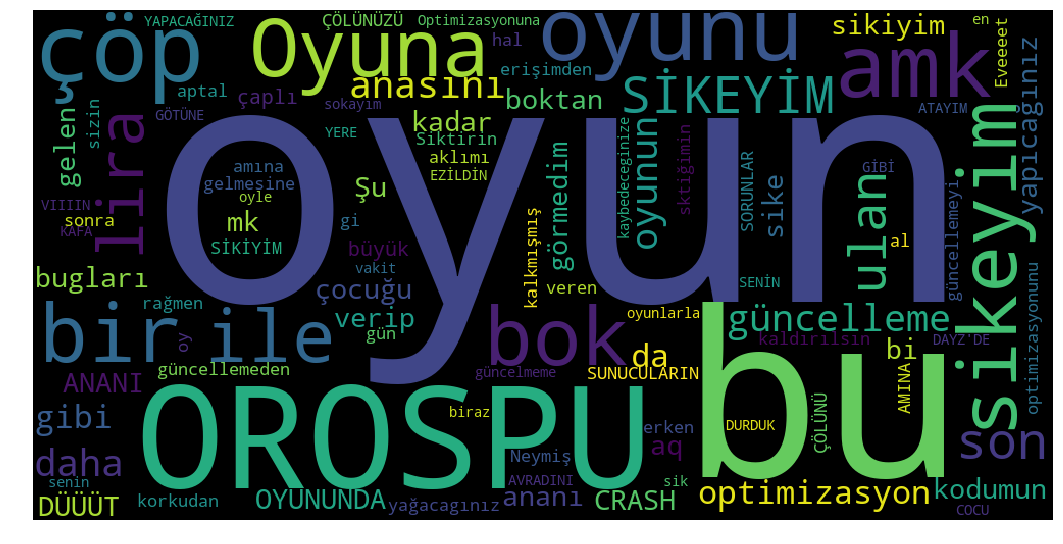

In [24]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS



r_train = train[train.toxic == 1]
print ("toxic count-",len(r_train))
print ("original word cloud of toxic")
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 1000, height = 500,
                          background_color='black',
                          stopwords=stopwords,
                          max_words=100
                         ).generate(str(r_train['yorum']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()